# Ahmed Nouralla - B19-CS-01 - a.shaaban@innopolis.university

# Sugges_

One of the strategies to improve user experience is to provide user with hints, or, otherwise, to autocomplete his queries. Let's consider suggest.

Today we will practice generating suggestions using [Trie](https://en.wikipedia.org/wiki/Trie) data structure (prefix tree), see the example below.

Plan of your homework:

1. Build Trie based on real search query data, provided by AOL company;
2. Generate suggestion based on a trie;
3. Measure suggestion speed;
4. [M] Add spellcheck to suggest.


![image](https://www.ritambhara.in/wp-content/uploads/2017/05/Screen-Shot-2017-05-01-at-4.01.38-PM.png)

In [1]:
!pip install pygtrie
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install tqdm
!pip install pyspellchecker

In [2]:
import string
import time
from typing import List
import pygtrie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from spellchecker import SpellChecker
import nltk

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## 0. Install Trie data structure support

You are free to use any library implementation of Trie, as well as the one we suggest (read the docs before asking any questions!): https://github.com/google/pygtrie

### 0.1. Check it works and understand the example

In [5]:
t = pygtrie.CharTrie()

# trie can be considered as a form of organizing a set of map
t["this is 1"] = "A"
t["this is 2"] = "B"
t["that is 3"] = "C"

print(t)

# "this" string is present in a set
n = t.has_node('this') == pygtrie.Trie.HAS_VALUE
# "this" prefix is present in a set
s = t.has_node('this') == pygtrie.Trie.HAS_SUBTRIE

print(f"Node = {n}\nSubtree = {s}")

# iterate a subtree
for key, val in t.iteritems("this"):
    print(key, '~', val)

CharTrie(this is 1: A, this is 2: B, that is 3: C)
Node = False
Subtree = True
this is 1 ~ A
this is 2 ~ B


## 1. Build a trie upon a dataset

### 1.1. [5] Read the dataset

Download the [dataset](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/aol) (we provide only the first part of the original data for simplicity (~3.5 mln queries)).

Explore the data, see readme file. Load the dataset. Pass the assert.

In [6]:
aol_data = pd.read_csv('aol/user-ct-test-collection-01.txt', sep='\t')

assert aol_data.shape[0] == 3558411, "Dataset size does not match"

In [7]:
aol_data

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,142,rentdirect.com,2006-03-01 07:17:12,NaN,NaN
1,142,www.prescriptionfortime.com,2006-03-12 12:31:06,NaN,NaN
2,142,staple.com,2006-03-17 21:19:29,NaN,NaN
3,142,staple.com,2006-03-17 21:19:45,NaN,NaN
4,142,www.newyorklawyersite.com,2006-03-18 08:02:58,NaN,NaN
...,...,...,...,...,...
3558406,24968114,-,2006-05-31 01:04:20,NaN,NaN
3558407,24969251,sp.trafficmarketplace.com,2006-05-31 15:51:23,NaN,NaN
3558408,24969374,orioles tickets,2006-05-31 12:24:51,NaN,NaN
3558409,24969374,orioles tickets,2006-05-31 12:31:57,2.0,http://www.greatseats.com


In [8]:
aol_data.dtypes

AnonID         int64
Query         object
QueryTime     object
ItemRank     float64
ClickURL      object
dtype: object

In [9]:
aol_data = aol_data.dropna(subset=['Query'])    # drop rows with null queries
aol_data = aol_data.drop(
    aol_data[aol_data.Query == '-'].index)      # drop rows with '-' queries
aol_data = aol_data.astype({'Query': 'string'}) # queries should be strings

### 1.2. [10] Build a Trie

We want a suggest function to be **non-sensitive to stop words** because we don't want to upset the users if they confuses/omits prepositions. Consider *"public events in Innopolis"* vs *"public events at Innopolis"* or *"public events Innopolis"* - they all mean the same.

Build a Trie based on the dataset, **storing query statistics such as query _frequency_, urls and ranks in the nodes**. Some queries may have no associated urls, others may have multiple ranked urls. Think of the way to store this information.

Pass the asserts.

In [10]:
sw = stopwords.words('english')

# trie[key] = { query: TrieNode(freq=X, urls=[(rank, url)])}
class TrieNode():
    def __init__(self):
        self.freq = 1
        self.urls = []
    def __repr__(self):
        return f'TrieNode(freq={self.freq}, urls={self.urls})'

def build_trie(dataset):
    trie = pygtrie.CharTrie()
    for row in tqdm(dataset.itertuples(), total=dataset.shape[0]):
        query, rank, url = row.Query, row.ItemRank, row.ClickURL
        key = ' '.join([w for w in query.split() if (not w in sw)])
        if not key:
            continue

        if trie.has_key(key):
            if trie[key].get(query):
                trie[key][query].freq += 1
            else:
                trie[key][query] = TrieNode()
        else:
            trie[key] = {query: TrieNode()}

        if not pd.isnull(url):
            trie[key][query].urls.append((rank, url))
    return trie

aol_trie = build_trie(aol_data)

100%|██████████████████████████████| 3459247/3459247 [02:01<00:00, 28404.99it/s]


In [11]:
bag = []
for key, val in aol_trie.iteritems("sample q"):
    print(key, '~', val)
    
    for node in val.values():
        bag += [url[1] for url in node.urls]
    
    assert "sample question" in key, "All examples have `sample question` substring"
    assert key[:len("sample question")] == "sample question", "All examples have `sample question` starting string"

for url in ["http://www.surveyconnect.com", "http://www.custominsight.com", 
            "http://jobsearchtech.about.com", "http://www.troy.k12.ny.us",
            "http://www.flinders.edu.au", "http://uscis.gov"]:
    assert url in bag, "This url should be in a try"

sample question surveys ~ {'sample question surveys': TrieNode(freq=5, urls=[(7.0, 'http://www.surveyconnect.com'), (4.0, 'http://www.custominsight.com'), (10.0, 'http://www.askemployees.com'), (1.0, 'http://www.lg-employers.gov.uk')])}
sample questions immigration interview ~ {'sample questions for immigration interview': TrieNode(freq=1, urls=[])}
sample questions interview ~ {'sample questions for interview': TrieNode(freq=1, urls=[(1.0, 'http://www.quintcareers.com')])}
sample questions family interview ~ {'sample questions for family interview': TrieNode(freq=3, urls=[(2.0, 'http://www.grandparents-day.com'), (5.0, 'http://www.quintcareers.com'), (3.0, 'http://jobsearchtech.about.com')])}
sample questions sociology race ethnicity ~ {'sample questions sociology race and ethnicity': TrieNode(freq=1, urls=[])}
sample questions biology ~ {'sample questions biology': TrieNode(freq=2, urls=[(3.0, 'http://www.utexas.edu'), (6.0, 'http://www.troy.k12.ny.us')])}
sample questions us citizen

## 2. [15] Write a suggest function which is non-sensitive to stop words

Suggest options for user query based on Trie you just built.
Output results sorted by frequency, print query count for each suggestion. If there is an url available, print the url too. If multiple url-s are available, print the one with the highest rank (the less the better).

Pass the asserts.

Question for analysis: What is the empirical threshold for minimal prefix for suggest? Well, Google starts suggesting completions even when only 1 letter is written.

In [12]:
# Displays results as pandas dataframe for IPython (jupyter, colab)
def show_results(results):
    try:
        from IPython.display import display
    except ImportError:
        return
    
    df = pd.DataFrame(data=results, columns=['Query', 'Count', 'Top URL'])
    df_styled = df.style.set_properties(**{'text-align': 'left'})
    df_styled.hide(axis='index')
    df_styled.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(df_styled)
    
# Suggests top_k completions for user query based on query frequencies from trie
def complete_user_query(query: str, trie, top_k=5, display=False) -> List[str]:
    query = query.lower()
    query = query.translate(dict.fromkeys(string.punctuation))         
    key = ' '.join([w for w in word_tokenize(query) if (not w in sw)])
    
    results = []
    try:
        for key, dic in trie.iteritems(key):
            for query, node in dic.items():
                url = max(node.urls, key=lambda x: x[0])[1] if node.urls else np.nan
                results.append((query, node.freq, url))
    except KeyError:
        return []
    
    results = sorted(results, key=lambda x: -x[1])
    if display:
        show_results(results)
    
    return [q for q in results][:top_k]


inp = "trie"
print("Query:", inp)
print("Results:")
res = complete_user_query(inp, aol_trie, display=True)
print(res)

assert res[0][0] == "tried and true tattoo"
assert res[1][0] == "triest" or res[1][0] == "triethanalomine"

assert "boys and girls club of conyers georgia" \
            in complete_user_query("boys girls club conyers", aol_trie, 10)[0], "Should be here"

Query: trie
Results:


Query,Count,Top URL
tried and true tattoo,5,http://www.tattoonow.com
triest,3,nan
triethanalomine,3,http://www.amazon.com
tried and failed,2,nan
when you tried and failed,2,nan
tried and truechildren's consignment sale,1,nan
i tried and the same thing happened. just the gray pinstripe background showed up without any pictures. i am on the road actually i'm in california and am accessing from a hotel. it might have something to do with security settings. i will try it a,1,nan
i tried out the cycling class and the bike seat hurt my private area,1,http://www.bycycleinc.com
i tried to be perfect but nothing was worth it lyrics,1,nan
trier germany,1,http://www.trier.de


[('tried and true tattoo', 5, 'http://www.tattoonow.com'), ('triest', 3, nan), ('triethanalomine', 3, 'http://www.amazon.com'), ('tried and failed', 2, nan), ('when you tried and failed', 2, nan)]


## 3. Measure suggest speed ##

### 3.1. [10] Full Trie test

Check how fast your search is working. Consider changing your code if it takes too long on average.

Sucess criterion:
- there is an average and variance for **multiple runs** of the given bucket.
- there is an average and variance for **multiple runs** of naive search in unindexed dataset.

In [13]:
# complete_user_query() but implemented without a trie (for comparison)
def naive_suggest(query, dataset, top_k=5):
    query = query.lower()
    query = query.translate(dict.fromkeys(string.punctuation))         
    key = ' '.join([w for w in word_tokenize(query) if (not w in sw)])
    freq = {}
    results, indexed_results = set(), []
    
    for item in dataset.itertuples():
        query = item.Query
        freq[query] = freq.get(query, 0) + 1
        if query.startswith(key) or (' ' + key in query):
            results.add(query)
            
    for result in results:
        indexed_results.append((freq[result], result))
        
    indexed_results = sorted(indexed_results, key=lambda x: -x[0])
    return [q[1] for q in indexed_results][:top_k]

In [21]:
inp_queries = ["inf", "the best ", "information retrieval", "sherlock hol", "carnegie mell", 
               "babies r", "new york", "googol", "inter", "USA sta", "Barbara "]

times_with_trie = []
times_without_trie = []

for inp in tqdm(inp_queries):
    # print(f"Query: {inp}")
    
    start = time.time()
    res = complete_user_query(inp, aol_trie)
    end = time.time()
    times_with_trie.append(end - start)
    # print(f"Result with trie: {res}")
    
    start = time.time()
    res = naive_suggest(inp, aol_data)
    end = time.time()
    times_without_trie.append(end - start)
    # print(f"Result without trie: {res}\n")
    
    
print('Stats with trie')
print(f'Average: {np.mean(times_with_trie)} seconds')
print(f'Variance: {np.var(times_with_trie)} seconds')
print()
print('Stats without trie')
print(f'Average: {np.mean(times_without_trie)} seconds')
print(f'Variance: {np.var(times_without_trie)} seconds')

100%|███████████████████████████████████████████| 11/11 [00:53<00:00,  4.83s/it]

Stats with trie
Average: 0.011086095463145863 seconds
Variance: 0.00021995286674572235 seconds

Stats without trie
Average: 4.82217415896329 seconds
Variance: 0.06875775264961986 seconds


### 3.2. [M][10] Assess how dataset size affect search time

Study the speed of the trie data structure in $\frac{1}{10}, \frac{1}{4}, \frac{1}{2}$, and full dataset. 
- Sample the data at random.
- Plot the graph which shows how search time changes with dataset size.
- Compare aganist bruteforce.

In [22]:
fracs = [0.1, 0.25, 0.5, 1]
x = ['1/10', '1/4', '1/2', '1']
y1, y2 = [], []

for frac in fracs:
    sample = aol_data.sample(frac=frac, axis=0, random_state=0)
    trie = build_trie(sample)
    
    times1, times2 = [], []
    for inp in tqdm(inp_queries):
        start = time.time()
        res = complete_user_query(inp, trie)
        end = time.time()
        times1.append(end - start)

        start = time.time()
        res = naive_suggest(inp, sample)
        end = time.time()
        times2.append(end - start)
    
    y1.append(np.mean(times1))
    y2.append(np.mean(times2))

100%|███████████████████████████████████████████| 11/11 [01:08<00:00,  6.22s/it]


In [23]:
# To free memory
del sample
del trie
import gc
gc.collect()

164

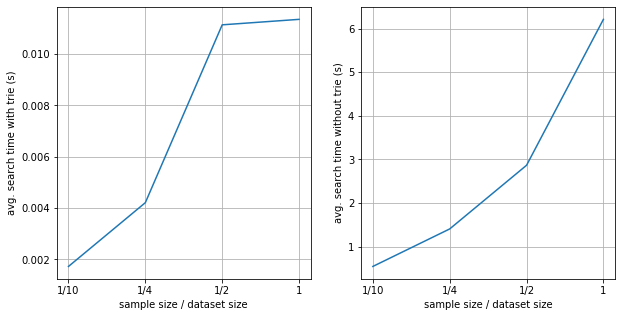

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y1)
plt.xlabel('sample size / dataset size')
plt.ylabel('avg. search time with trie (s)')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, y2)
plt.xlabel('sample size / dataset size')
plt.ylabel('avg. search time without trie (s)')
plt.grid()

plt.show()

## 4. [10] Add spellchecking to your suggest

Try to make your search results as close as possible. Compare top-5 results of each query with top-5 results for corrected.

You can use use [pyspellchecker](https://pypi.org/project/pyspellchecker/) `candidates()` call, or use any other spellchecker implementation.

In [18]:
def complete_user_query_with_spellchecker(query, trie, top_k=5) -> List[str]:
    checker = SpellChecker()
    query = query.lower()
    query = query.translate(dict.fromkeys(string.punctuation))
    words = word_tokenize(query)
    results = []
    for i in range(len(words)):
        for correction in checker.candidates(words[i]):
            if words[i] == correction: # word is already correct
                continue
            words[i] = correction  # try that correction
            res = complete_user_query(' '.join(words), trie)
            if res:
                results.append((res[0][1], res))
    
    # The result with max frequency of first item is the best correction.
    # If no corrections were applied, call the original complete_user_query
    results = sorted(results, key=lambda x: -x[0])
    return results[0][1] if results else complete_user_query(query, trie)

In [19]:
inp_queries = ["inormation retrieval", "shelrock hol", "carnagie mell", "babis r", "Barrbara "]
inp_queries_corrected = ["information retrieval", "sherlock hol", "carnegie mell", "babies r", "Barbara "]

for q, qc in zip(inp_queries, inp_queries_corrected):
    assert  complete_user_query(qc, aol_trie, 5) == \
            complete_user_query_with_spellchecker(q, aol_trie, 5), "Assert {} and {} give different results".format(q, qc)